In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
import random
import numpy as np
import numpy.matlib
import matplotlib.pylab as plt
from mpl_toolkits import axes_grid1
from FH_Functions import opt_fracs
from GP_Functions import EXP_predict, search_data

In [2]:
def prog_search(N_strips, N_samps, lam, mu, l, mu_init=False):
    """Function to generate the multiple progressive plots of a single search"""
    N = 1000
    theta = np.linspace(0,2*np.pi,N)
    SIG = EXP_cov(theta,theta,l)

    yy = np.random.multivariate_normal(mean=mu*np.ones(N), cov=SIG)
    sampLocs = []
    samps = np.linspace(0,2*np.pi,N_strips+1)
    for samp in samps:
        sampLocs.append(np.argmin(np.abs(samp-theta)))
    sampLocs = np.asarray(sampLocs)
    sampVals = yy[sampLocs]

    strip_locs = np.array([2*np.pi])    
    f2 = plt.figure(figsize=(12,12))
    plt.rc('font',family='serif')
    tps = []
    sps = []
    for ii, tht in enumerate(sampVals[:-1]):
        if not ii:
# ****** version 1 - start at mu *******
            if mu_init:
                x_init = mu 
                if mu < tht:
                    lb = mu
                    ub = 2*mu
                else:
                    ub = mu        
                    lb = 0
# ****** version 2 - start at origin ***
            else:
                x_init = 0 
                lb = 0
                ub = 2*mu

        else: 
            x_init = y_pred[sampLocs[ii]]
            if x_init < tht:
                lb = x_init
                ub = 2*mu
            else:
                ub = x_init        
                lb = 0
                
        ls = search_data()
        policy = opt_fracs(N_samps, lam)
        ls.GP_search(policy, tht, ub, lb, x_init)
        thtEst = ls.est
        if not ii:
            tht_ests = np.array([thtEst, thtEst])
        else:
            tht_ests = np.insert(tht_ests,-1,thtEst)

        sp = np.array(ls.search_points)
        tp = theta[sampLocs[ii]]
        tps.append(tp)
        sps.append(sp)
     
        strip_locs = np.insert(strip_locs,-1,tp)
        
        f2.add_subplot(3,3,ii+1,projection='polar')
        plt.plot(theta,yy,'k',label = 'True boundary')
        
        epsilon = ls.intervals[-1]/2  # calculate the noise from last interval

        predictions = [EXP_predict(i, strip_locs, tht_ests, mu, mu, l, epsilon) for i in theta]
        y_pred, sigmas = np.transpose(predictions)

        plt.errorbar(theta, y_pred, yerr=1.96*sigmas, fmt='r', ecolor='0.6', 
                    capsize=0, label = 'Estimated boundary');

        plt.xticks([])
        plt.yticks(np.arange(0, 2*mu, step=1),[])
        plt.ylim([0,yy.max()+0.4])
        if not ii:
            plt.plot((0,tp),(0,thtEst), color='r', ls='--', label = 'Search strip')
            plt.plot(tp*np.ones(N_samps+1),sp,'bo', label = 'Search points') # search points     
            plt.legend(loc='upper right', bbox_to_anchor=(4.6,1.0), fontsize=15);
        else:
            for jj in range(ii+1):
                plt.plot((0,tps[jj]),(0,tht_ests[jj]), color='r', ls='--')
                a = tps[jj]
                plt.plot(a*np.ones(N_samps+1),sps[jj],'bo') # search points
#     plt.savefig('Prog_search_6.eps',bbox_inches='tight')


def circle_search(N_strips, N_samps, lam, mu, l, epsilon, seed=0):
    """Function to generate the single plot of a search"""
    policy = opt_fracs(N_samps,lam)
    N = 1000
    theta = np.linspace(0,2*np.pi,N)
    SIG = EXP_cov(theta,theta,l)
    
    np.random.seed(seed)

    yy = np.random.multivariate_normal(mean=mu*np.ones(N), cov=SIG)
    sampLocs = []
    samps = np.linspace(0,2*np.pi,N_strips+1)
    for samp in samps:
        sampLocs.append(np.argmin(np.abs(samp-theta)))
    sampLocs = np.asarray(sampLocs)
    sampVals = yy[sampLocs]
    X = yy * np.cos(theta)
    Y = yy * np.sin(theta)
    
    tht_ests = []
    
    f2 = plt.figure()
    a2 = f2.add_subplot(111, projection='polar')
    plt.rc('font',family='serif')
    a2.plot(theta,yy,'k',label = 'True boundary')
    
    for ii, tht in enumerate(sampVals[:-1]):
        if not ii:
            lb = 0
            ub = 2*mu
            x_init = 0
        else:
            if thtEst < tht:
                lb = thtEst
                ub = 2*mu
            else:
                ub = thtEst        
                lb = 0
            x_init = thtEst
        ls = search_data()
        policy = opt_fracs(N_samps, lam)
        ls.GP_search(policy, tht, ub, lb, x_init)
        thtEst = ls.est
        tht_ests.append(thtEst)
        sp = np.array(ls.search_points)
        tp = theta[sampLocs[ii]]

        if not ii:
            a2.plot((0,tp),(0,thtEst), color='r', ls='--', label = 'Search strip')
            a2.plot(tp*np.ones(len(sp)),sp,'bo', label = 'Search points') # search points
            
        else:
            a2.plot((0,tp),(0,thtEst), color='r', ls='--')
            a2.plot(tp*np.ones(len(sp)),sp,'bo') # search points
    a2.plot(0,0,'bo')
         
    tht_ests.append(tht_ests[0])
    tht_ests = np.array(tht_ests)
    predictions = [EXP_predict(i, theta[sampLocs], tht_ests, mu, mu, l, epsilon) for i in theta]
    y_pred, sigmas = np.transpose(predictions)

    a2.errorbar(theta,y_pred, yerr=1.96*sigmas, fmt='r', ecolor='0.6', 
                capsize=0, label = 'Estimated boundary');
    plt.xticks([])
    plt.yticks(np.arange(0, 2*mu, 1))
    a2.set_yticklabels([])
    a2.set_xticklabels([])
    return f2, a2
#     plt.legend(loc='upper right', bbox_to_anchor=(1.7,1.0));
    
#     plt.savefig('sample_c1_2.eps',bbox_inches='tight')


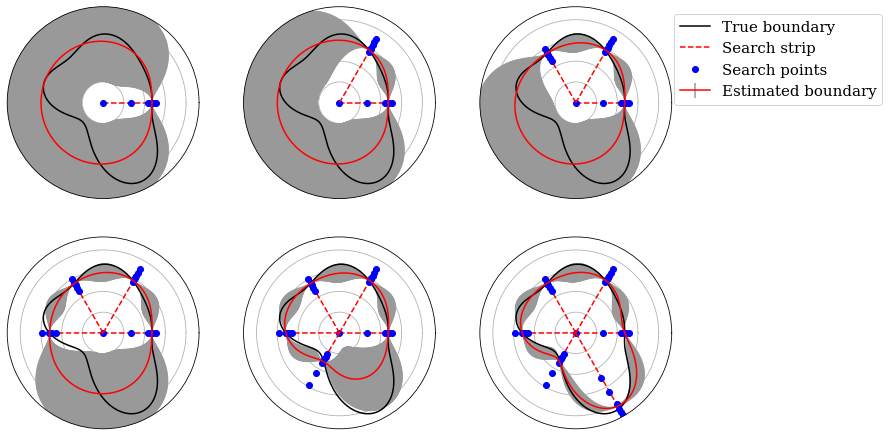

In [3]:
N_strips = 6 # max = 9
N_samps = 5  # samples per strip (N for policy after initial sample)
lam = 0.4    # distance penalty
mu = 3       # mean boundary distance
l = 0.6      # Length scale for covariance kernel
prog_search(N_strips, N_samps, lam, mu, l)

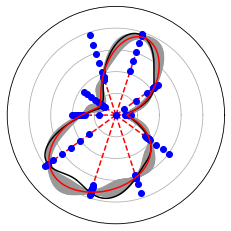

In [4]:
N_strips = 10
N_samp = 10   # N for policy after initial sample on each strip
lam = 0.4
mu = 3        # mean distance from origin
l = 0.4       # length scale for covariance kernel
epsilon = 0.25 # noise on GP
f1, a1 = circle_search(N_strips, N_samp, lam, mu, l, epsilon)

50551


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


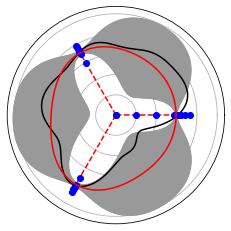

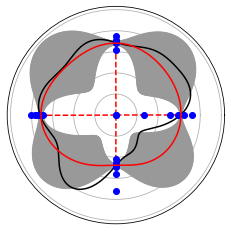

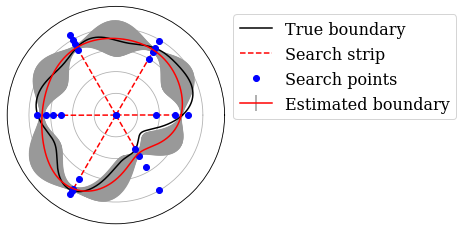

In [57]:
# Ns = np.arange(3,8,2)
Ns = [3, 4, 6]
seed = np.random.randint(100000)
l = 0.5
print(seed)
N_strips = 3
N_samp = 6
seed = 245

for ii, N_strips in enumerate(Ns):
    N_samp = int(24 / N_strips)
    f1, a1 = circle_search(N_strips, N_samp-1, lam, mu, l, epsilon, seed)
    if ii == 2:
        a1.legend(loc='upper right', bbox_to_anchor=(2.1,1.0),fontsize=16)
#     f1.tight_layout()
    f1.savefig('%d_strips_compare.eps'%N_strips,bbox_inches='tight')
